In [8]:
# Python 3.7
# Discord bot that analyzes sentiment for different crypto over the last 24 hours and messages then in discord server

import twitter
import os
import datetime
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import time 
from IPython.display import clear_output


In [10]:
# insert twitter API keys here


consumer_key = input('Insert consumer_key: ')
consumer_secret = input('Insert consumer_secret: ')
access_token_key = input('Insert access_token_key: ')
access_token_secret = input('Insert access_token_secret: ') 

clear_output()

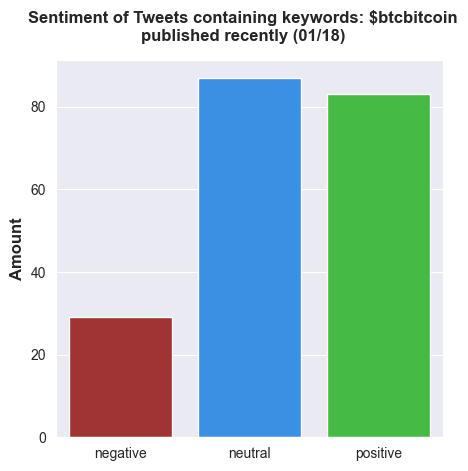

In [6]:
api = twitter.Api(
    consumer_key=str(consumer_key),
    consumer_secret=str(consumer_secret),
    access_token_key=str(access_token_key),
    access_token_secret=str(access_token_secret),
    tweet_mode="extended",
)



keywords = ['$btc','bitcoin']

def twitterSearch(keyword):
    searchResults = []
    searchResults += api.GetSearch(term = keyword,count = 100, result_type = 'popular')
    searchResults += api.GetSearch(term = keyword,count = 100, result_type = 'mixed' )
    searchResults += api.GetSearch(term = keyword,count = 100, result_type = 'recent')
    return searchResults

search_results = []

for word in keywords:
    search_results += twitterSearch(word)
    time.sleep(10)

tweets_text = []
tweets_authors = []
date_for_query = datetime.datetime.now()
for tweet in search_results:
    # CAVEAT: consider only a single tweet from one author - 
    #this will ensure that a total sentiment is an opinion of multiple tweeter's users, not just a single one
    if tweet.user not in tweets_authors:
        tweets_authors.append(tweet.user)
    else:
        continue
    tweet_text = tweet.full_text
    
    if "@" in tweet_text:
        tweet_text = re.sub("(@)\w+", "", tweet_text)
    if "#" in tweet_text:
        tweet_text = re.sub("(#)\w+", "", tweet_text)
    
    
    if len(tweet_text) > 20:
        tweets_text.append(tweet_text.lstrip())

def vader_sentiment_score(tweet_text: str) -> float:
    return round(
        SentimentIntensityAnalyzer().polarity_scores(tweet_text)["compound"], 3
    )

sentiment_score_vader = []
for tweet in tweets_text:
    sentiment_score_vader.append(vader_sentiment_score(tweet))
    
sentiment_score_vader
sentiment_list = []
for score in sentiment_score_vader:
    if score < -0.05:
        sentiment_list.append("negative")
    elif -0.05 <= score <= 0.05:
        sentiment_list.append("neutral")
    elif score > 0.05:
        sentiment_list.append("positive")

        
x_axis = ["negative", "neutral", "positive"]
y_axis = [
    sentiment_list.count("negative"),
    sentiment_list.count("neutral"),
    sentiment_list.count("positive"),
]
colors = ['firebrick', 'dodgerblue', 'limegreen']
sns.set_palette(sns.color_palette(colors))
sns.set_style("darkgrid")
fig = plt.figure(figsize=(5, 5),dpi= 100)

ax = plt.axes()
ax.set_ylabel("Amount", weight="bold", fontsize="large")
sns.barplot(x=x_axis, y=y_axis)

if False:
    fig.suptitle(
        f"Sentiment of Tweets containing keywords: {', '.join(keywords).replace('[', '').replace(']', '')}\ndated for period: {date_for_query.strftime('%d.%m')} - {datetime.date.today().strftime('%d.%m')}",
        weight="bold",
    )
else:
    fig.suptitle(
        f"Sentiment of Tweets containing keywords: {''.join(keywords).replace('[', '').replace(']', '')}\npublished recently ({date_for_query.strftime('%m/%d')})",
        weight="bold",
    )
plt.savefig('Sentiment.png')
